# CSI 5810 Project 1 - Bank Marketing
## Samantha Bracellari

-----

## OBJECTIVE

This project is aimed at building a predictive model to help a bank with its direct marketing. The bank has historical data for over 45,000 customers to build a predictive model to predict whether a customer will go for term deposit or not by using the attributes bank has in its database.

You will use only those classifiers that have been discussed in the class. You must perform N-fold cross validation of your models and report mean and standard deviation of any performance metric you use.

-----

### PART 1: INITIALIZATION

Import statements, variable declaration, etc.

       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

<AxesSubplot:>

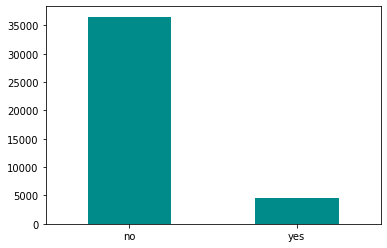

In [3]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# read bank data into a pandas dataframe
bank = pd.read_csv('bank-additional-full.csv', sep=';') 

# define data
X = bank.iloc[:, 0:20] # original predictors
y = bank['y'] # target

########## DATA PREVIEW ##########
print(X)

# histogram of target variable
bank['y'].value_counts(normalize=False).plot.bar(rot=0, color='darkcyan')

-----

### PART 2: DOMAIN UNDERSTANDING

#### DATA CHARACTERISTICS

Below are descriptions of each feature as provided by UCI

**Input variables (predictors)**

*bank client data:*  
1. age (numeric)  
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5. default: has credit in default? (categorical: 'no','yes','unknown')  
6. housing: has housing loan? (categorical: 'no','yes','unknown')  
7. loan: has personal loan? (categorical: 'no','yes','unknown')  

*related with the last contact of the current campaign:*  
8. contact: contact communication type (categorical: 'cellular','telephone')  
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  

*other attributes:*  
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
14. previous: number of contacts performed before this campaign and for this client (numeric)  
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  

*social and economic context attributes:*  
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17. cons.price.idx: consumer price index - monthly indicator (numeric)  
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)  
19. euribor3m: euribor 3 month rate - daily indicator (numeric)  
20. nr.employed: number of employees - quarterly indicator (numeric)  

**Output variable (desired target):**  

21. y - has the client subscribed a term deposit? (binary: 'yes','no')

#### DATA VISUALIZATION

Visualization was performed on the dataset after feature selection took place, but the two processes are written about in opposite order in the report for the sake of flow. You will see the graphs for visualization in the `Feature Analysis and Selection` section.

-----

### PART 3: FEATURE ANALYSIS AND SELECTION

The following 5 aspects were considered when eliminating features of the dataset:

1. duplicate features
2. features with a significant amount of missing/null values (more than 50%)
3. features that are not correlated with the target
4. features with too much variation
5. features with too little variation (80% or more of the feature is one value)

For this dataset in particular, the only applicable process was (5), features with too little variation. The following features were removed following this process:

- `default`
- `loan`
- `pdays`
- `previous`
- `poutcome`

The `duration` feature was also removed per the suggestion of UCI. This leaves us with 14 remaining features.


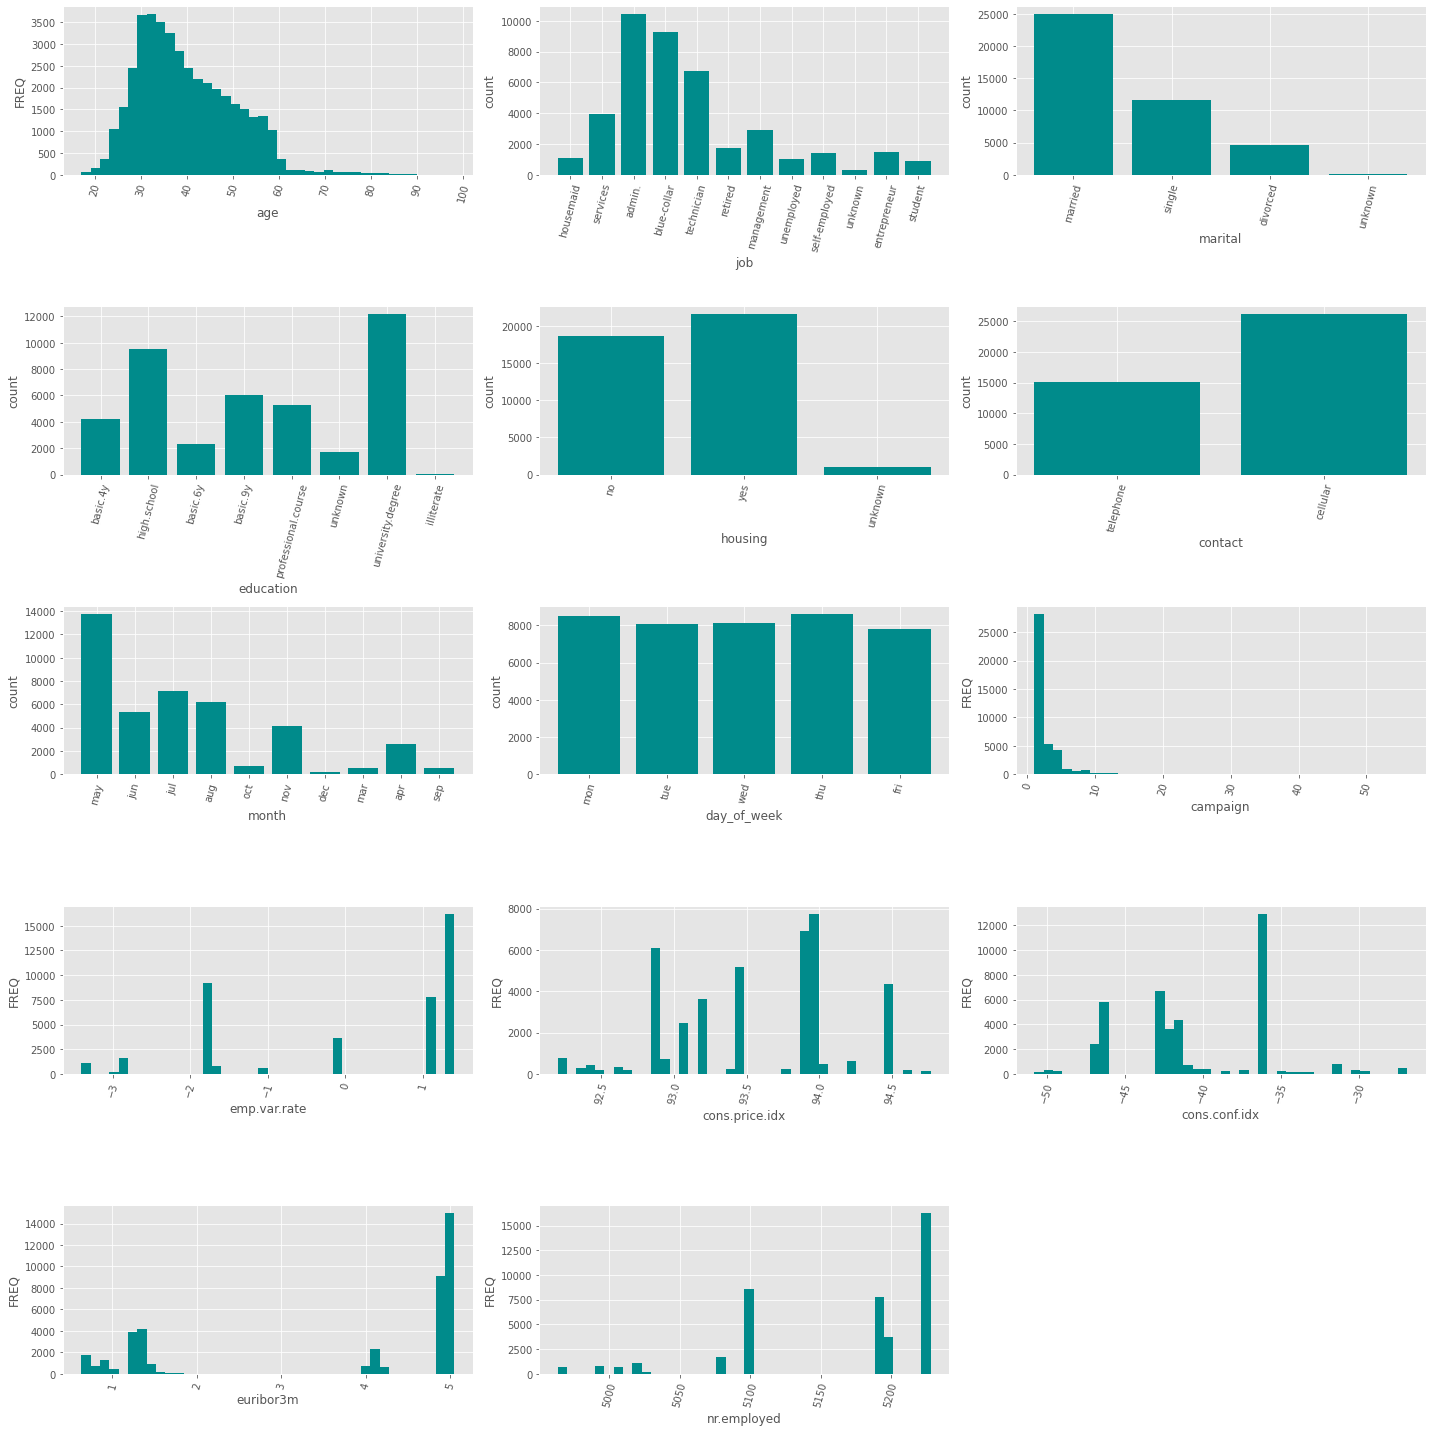

In [4]:
# reduce data down to the necessary features
features = ['age', 'job', 'marital', 'education', 'housing', 'contact', 'month', 'day_of_week', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
X = X[features]

# plot histograms of the remaining features
fig, axs = plt.subplots(5, 3, sharey=True, tight_layout=True, figsize=(20,20))
plt.subplots_adjust(hspace=1.5, wspace=1.5)
plt.style.use('ggplot')

i = 0
for col in features:
    i += 1
    plt.subplot(5, 3, i)
    
    if isinstance(X[col][0], np.int64) or isinstance(X[col][0], np.float64):
        plt.hist(X[col], color='darkcyan', bins=40)
        plt.ylabel('FREQ')
    else:
        value = {}
        for v in X[col]:
            if v in value.keys():
                value[v] += 1
            else:
                value[v] = 1
        options = value.keys()
        counts = value.values()
        plt.ylabel('count')
        plt.bar(options,counts, color='darkcyan')
        
    plt.xlabel(col)
    plt.xticks(rotation=75)

plt.delaxes(axs[4][2])
plt.show()

-----

### PART 4: DATA TRANSFORMATION

#### FEATURE SCALING

Scale all the remaining numerical features so that they have mean 0 and unit variance

In [5]:
# scale the numeric columns
for col in features:
    if isinstance(X[col][0], np.int64) or isinstance(X[col][0], np.float64):
      X[col] = scale(X[col])

print(X)

            age          job  marital            education housing    contact  \
0      1.533034    housemaid  married             basic.4y      no  telephone   
1      1.628993     services  married          high.school      no  telephone   
2     -0.290186     services  married          high.school     yes  telephone   
3     -0.002309       admin.  married             basic.6y      no  telephone   
4      1.533034     services  married          high.school      no  telephone   
...         ...          ...      ...                  ...     ...        ...   
41183  3.164336      retired  married  professional.course     yes   cellular   
41184  0.573445  blue-collar  married  professional.course      no   cellular   
41185  1.533034      retired  married    university.degree     yes   cellular   
41186  0.381527   technician  married  professional.course      no   cellular   
41187  3.260295      retired  married  professional.course     yes   cellular   

      month day_of_week  ca

#### DATA ENCODING

Transform the categorical data into numerical equivalents using `get_dummies`, then compress data back into its original shape to remove the multicollinearity that the use of `get_dummies` inroduced.

In [6]:
dummies = pd.get_dummies(X, drop_first=True)
print(dummies)

#Create a new copy of the data
X_labeled = X

nominal = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'day_of_week']
numeric = [item for item in X if item not in nominal]
print(pd.DataFrame(X[numeric]).head(5))

#Label encode the nominal features
le = LabelEncoder()
for feature in nominal:
    X_labeled[feature] = le.fit_transform(X[feature].astype(str))

print(X_labeled)

            age  campaign  emp.var.rate  cons.price.idx  cons.conf.idx  \
0      1.533034 -0.565922      0.648092        0.722722       0.886447   
1      1.628993 -0.565922      0.648092        0.722722       0.886447   
2     -0.290186 -0.565922      0.648092        0.722722       0.886447   
3     -0.002309 -0.565922      0.648092        0.722722       0.886447   
4      1.533034 -0.565922      0.648092        0.722722       0.886447   
...         ...       ...           ...             ...            ...   
41183  3.164336 -0.565922     -0.752343        2.058168      -2.224953   
41184  0.573445 -0.565922     -0.752343        2.058168      -2.224953   
41185  1.533034 -0.204909     -0.752343        2.058168      -2.224953   
41186  0.381527 -0.565922     -0.752343        2.058168      -2.224953   
41187  3.260295  0.156105     -0.752343        2.058168      -2.224953   

       euribor3m  nr.employed  job_blue-collar  job_entrepreneur  \
0       0.712460     0.331680              

-----

### PART 5: PREDICTIVE MODELS

Classification models were chosen for this dataset as it is labeled data with a binary outcome. Two models, KNN and Naive Bayes, were chosen so that accuracy scores could be compared.

In [8]:
y = y.to_numpy().flatten()
X_train, X_test, y_train, y_test = train_test_split(dummies, y, test_size=0.20, random_state=42)

def report(y_test, y_pred):
    print('\nCALCULATING SKLEARN ACCURACIES')
    print('\nACCURACY SCORE:', accuracy_score(y_test, y_pred))
    print('PRECISION SCORE', precision_score(y_test,y_pred, average='weighted'))
    print('RECALL SCORE:', recall_score(y_test,y_pred, average='weighted'))
    print('\n')

#### K-NEAREST NEIGHBOR

PREDICTIVE MODEL ACCURACY: 0.8851663025006069

N-FOLD CROSS VALIDATION ACCURACY:  0.8450235646230791 +/- 0.15568183984592057

PREDICTED TARGET VALUES: ['no' 'no' 'no' ... 'no' 'no' 'no']

CALCULATING SKLEARN ACCURACIES

ACCURACY SCORE: 0.8851663025006069
PRECISION SCORE 0.8631431965401656
RECALL SCORE: 0.8851663025006069




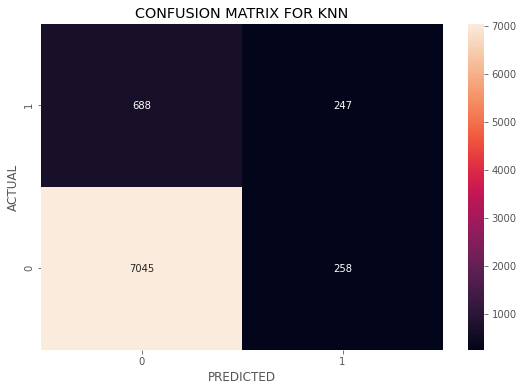

In [19]:
# train model and calculate its accuracy score
knn = KNeighborsClassifier(5).fit(X_train, y_train)
print('PREDICTIVE MODEL ACCURACY:', knn.score(X_test, y_test))

# perform N-Fold Cross Validation
knn1 = KNeighborsClassifier(10)
scores = cross_val_score(knn1, X.to_numpy(), y, cv=16)
print('\nN-FOLD CROSS VALIDATION ACCURACY: ', scores.mean(), '+/-', scores.std())

# predict target values
y_pred = knn.predict(X_test)
print('\nPREDICTED TARGET VALUES:', y_pred)

# generate accuracy report
report(y_test, y_pred)

# generate a confusion matrix
cf1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (9,6))
ax = sn.heatmap(cf1, annot=True, fmt='g')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('CONFUSION MATRIX FOR KNN')
ax.set_ylim(0, 2)
plt.show()

#### NAIVE BAYES

PREDICTIVE MODEL ACCURACY: 0.8640446710366594

N-FOLD CROSS VALIDATION ACCURACY:  0.7314357635352782 +/- 0.33834259180378784

PREDICTED TARGET VALUES: ['no' 'no' 'no' ... 'no' 'no' 'no']

CALCULATING SKLEARN ACCURACIES

ACCURACY SCORE: 0.8640446710366594
PRECISION SCORE 0.8602166746486305
RECALL SCORE: 0.8640446710366594




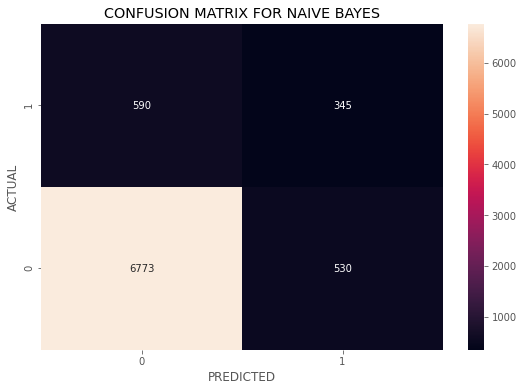

In [16]:
# train model and calculate its accuracy score
gnb = GaussianNB().fit(X_train, y_train)
print('PREDICTIVE MODEL ACCURACY:', gnb.score(X_test, y_test))

# perform N-Fold Cross Validation
gnb1 = GaussianNB()
scores = cross_val_score(gnb1, X.to_numpy(), y, cv=16)
print('\nN-FOLD CROSS VALIDATION ACCURACY: ', scores.mean(), '+/-', scores.std())

# predict target values
y_pred = gnb.predict(X_test)
print('\nPREDICTED TARGET VALUES:', y_pred)


# generate accuracy report
report(y_test, y_pred)

# generate confusion matrix
cf2 = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (9,6))
ax = sn.heatmap(cf2, annot=True, fmt='g')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('CONFUSION MATRIX FOR NAIVE BAYES')
ax.set_ylim(0, 2)
plt.show()